In [1]:
import sklearn
import sklearn.datasets
from matplotlib import pylab as plt
import numpy as np
from itertools import cycle,islice

In [2]:
import torch
import torchvision
import torchdiffeq

In [274]:
import models
import importlib
importlib.reload(models)
from models import *

In [231]:
colors = np.array(list(islice(cycle(
    ['#377eb8', '#ff7f00', '#4daf4a',
     '#f781bf', '#a65628', '#984ea3',
     '#999999', '#e41a1c', '#dede00']),
    int(max([1]) + 1))))

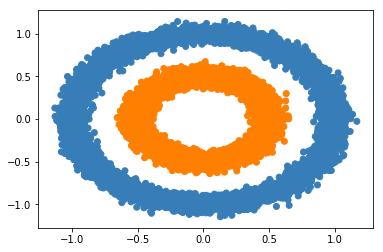

In [232]:
X,Y = sklearn.datasets.make_circles(n_samples=15000, factor=.5,
                                      noise=.05)
plt.scatter(X[:,0],X[:,1],color=colors[Y])

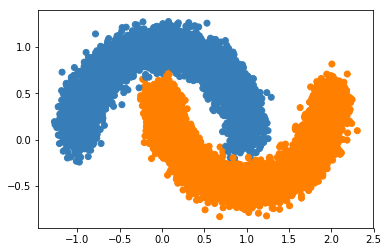

In [136]:
X,Y = sklearn.datasets.make_moons(n_samples=15000,noise=0.1)

plt.scatter(X[:,0],X[:,1],color=colors[Y])

In [152]:
def plot_pred(model):
    pred = torch.sigmoid(model( torch.tensor(X[:1000,:],dtype=torch.float32) ))
    P = pred.detach().numpy()
    P = np.array(np.around(P),dtype=np.int)
    plt.scatter(X[:1000,0],X[:1000,1],color=colors[list(P.flatten())])

In [116]:
dataset = torch.utils.data.TensorDataset(
    torch.tensor(X,dtype=torch.float),torch.tensor(Y,dtype=torch.float).reshape(-1,1))
loader = torch.utils.data.DataLoader(dataset,batch_size=64)

In [128]:
model = ShallowNet(2,1,hidden=4,Act=torch.nn.LeakyReLU)

In [123]:
model = DeepNet((2,4,4,4,1),Act=torch.nn.LeakyReLU)

In [283]:
class ODEModel(torch.nn.Module):
    def __init__(self,i_dim,o_dim,ode_width=4,Act=torch.nn.ReLU):
        super(ODEModel,self).__init__()
        self.net = torch.nn.Sequential(
            torch.nn.Linear(i_dim,ode_width),
            ODEBlock(
                ShallowODE(ode_width,hidden=12,Act=Act),
                method='rk4'),
            #ODEBlock(ShallowODE(ode_width,hidden=12,Act=Act)),
            torch.nn.Linear(ode_width,o_dim),
        )
    def forward(self,x):
        y = self.net(x)
        return y
    def refine(self):
        new = copy.deepcopy(self)
        return new

In [284]:
model = ODEModel(2,1,ode_width=4,Act=torch.nn.LeakyReLU)

In [285]:
criterion = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1.0e-3)
epochs=2
N_print=50
step_count = 0
losses = []

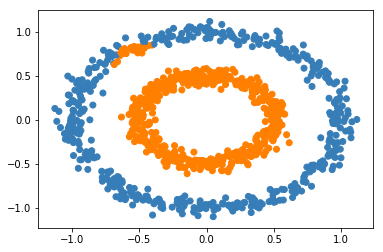

tensor(0.0626)


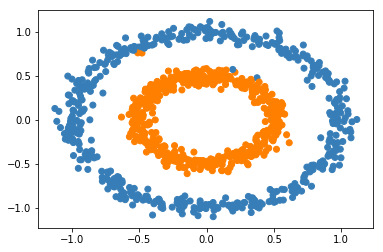

tensor(0.0263)


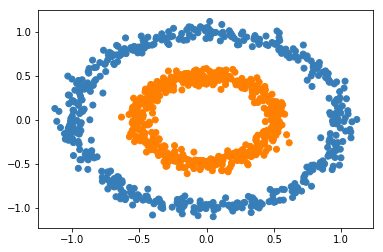

tensor(0.0121)


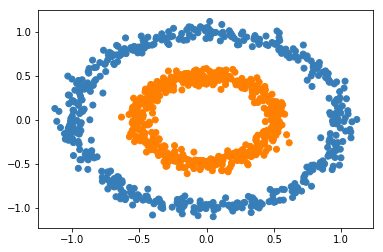

tensor(0.0052)


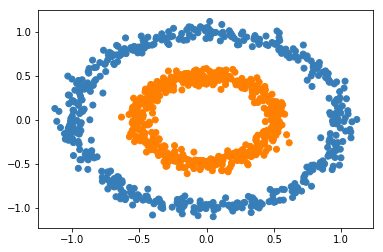

tensor(0.0050)


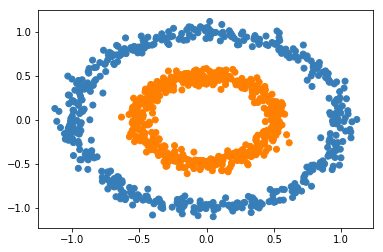

tensor(0.0027)


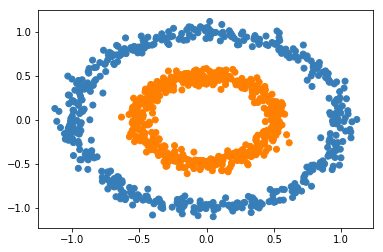

tensor(0.0020)


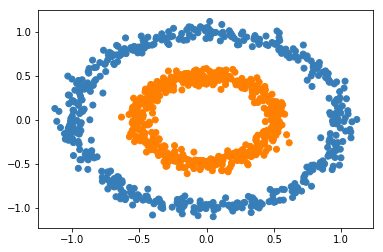

tensor(0.0016)


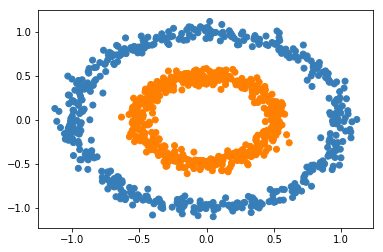

tensor(0.0224)


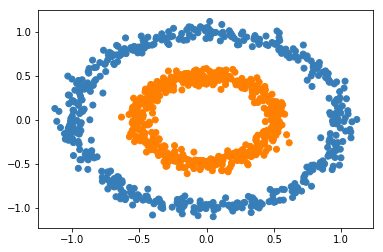

tensor(0.0036)


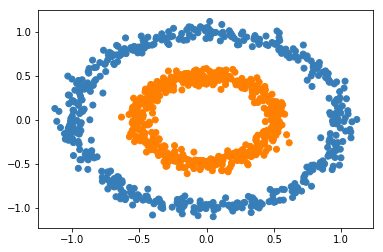

In [291]:
plot_pred(model)
plt.show()
for e in range(epochs):
    for imgs,labels in iter(loader):
        #imgs = imgs.reshape(-1,784)
        #print(imgs.shape)
        optimizer.zero_grad()
        #loss = -torch.log()
        out = model(imgs)
        #print(out,labels)
        L = criterion(out,labels)
        L.backward()
        optimizer.step()
        losses.append(L.detach().numpy())
        if step_count % N_print == N_print-1:
            print(L.detach())
            plot_pred(model)
            plt.show()
        step_count += 1

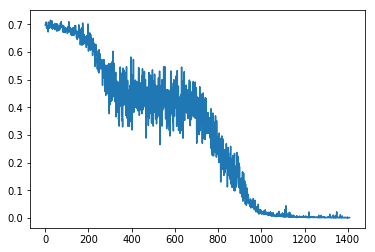

In [293]:
plt.plot(losses)